In [1]:
from PIL import Image
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import random

In [2]:
# load the data

# training

glioma_train = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Training/glioma_tumor/*")
meningioma_train = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Training/meningioma_tumor/*")
pituitary_train = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Training/pituitary_tumor/*")
healthy_train = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Training/no_tumor/*")

# test

glioma_test = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Testing/glioma_tumor/*")
meningioma_test = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Testing/meningioma_tumor/*")
pituitary_test = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Testing/pituitary_tumor/*")
healthy_test = glob.glob("C:/Users/almag/Desktop/CS156/braintumor/Testing/no_tumor/*")

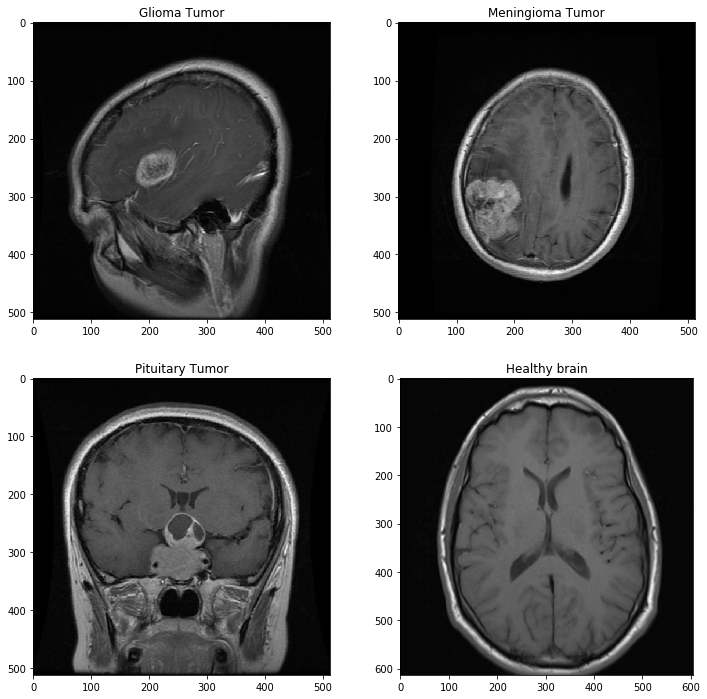

In [3]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(Image.open(glioma_train[5]))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(Image.open(meningioma_train[12]))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(Image.open(pituitary_train[13]))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(Image.open(healthy_train[2]))
ax1.title.set_text('Glioma Tumor')
ax2.title.set_text('Meningioma Tumor')
ax3.title.set_text('Pituitary Tumor')
ax4.title.set_text('Healthy brain')

In [4]:
glio_train = [] 
menin_train = []
pitui_train = []
notum_train = []

glio_test = []
menin_test = []
pitui_test = []
notum_test = []


def preprocessing(data, new):
    for pic in data:
        img = Image.open(pic)
        img = img.resize((20, 20), resample=0)
        img = np.array(img).flatten()
        new.append(img) 
        
preprocessing(glioma_train, glio_train)
preprocessing(meningioma_train, menin_train)
preprocessing(pituitary_train, pitui_train)
preprocessing(healthy_train, notum_train)
        
preprocessing(glioma_test, glio_test)
preprocessing(meningioma_test, menin_test)
preprocessing(pituitary_test, pitui_test)
preprocessing(healthy_test, notum_test)

In [5]:
# tumors class (train and test)

glio_train = pd.DataFrame(glio_train)
menin_train = pd.DataFrame(menin_train)
pitui_train = pd.DataFrame(pitui_train)

# all tumors train data
tumors_train = [glio_train, menin_train, pitui_train]
tumors_train = pd.concat(tumors_train)

glio_test = pd.DataFrame(glio_test)
menin_test = pd.DataFrame(menin_test)
pitui_test = pd.DataFrame(pitui_test)

# all tumors test data
tumors_test = [glio_test, menin_test, pitui_test]
tumors_test = pd.concat(tumors_test)

# all data

tumors = [tumors_train, tumors_test]
tumors = pd.concat(tumors)

# the division of data into test vs train

print('Training data:', 100-round(len(tumors_test)/len(tumors_train)*100, 2), '%',
      '\n' 'Testing data:', round(len(tumors_test)/len(tumors_train)*100, 2),'%')

Training data: 88.32 % 
Testing data: 11.68 %


In [6]:
# healthy class 

notum_train = pd.DataFrame(notum_train)
notum_test = pd.DataFrame(notum_train)

# all data

healthy = [notum_train, notum_test]
healthy = pd.concat(healthy)

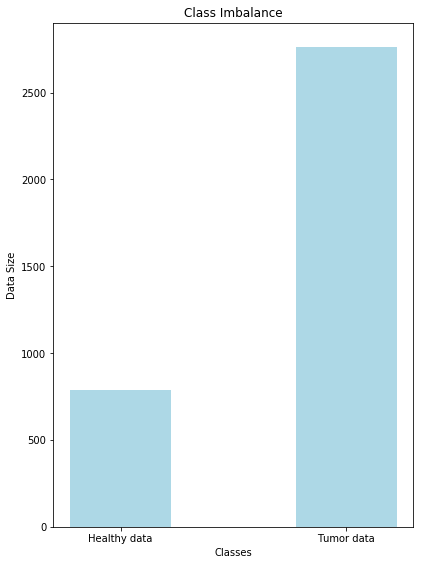

In [7]:
fig = plt.figure(figsize=(5,7))

ax = fig.add_axes([0,0,1,1])

data_des = ['Healthy data', 'Tumor data']
data_len = [len(healthy), len(tumors)]

ax.bar(data_des, data_len, color='lightblue', width = 0.45)

ax.set_xlabel('Classes')
ax.set_ylabel('Data Size')
ax.set_title('Class Imbalance')

plt.show()

In [8]:
n = len(notum_train)
m = len(notum_test)

In [15]:
# class balance
tumors_train_r = tumors_train[0:n]
tumors_test_r = tumors_test[0:m]

tumor = [tumors_train_r, tumors_test_r]
tumor = pd.concat(tumor)

In [18]:
# labelling

tumor = np.array(tumor)
healthy = np.array (healthy)

tumor_l = np.asarray([(pic, 1) for pic in tumor])
healthy_l = np.asarray([(pic, 0) for pic in healthy])

X = np.append(tumor_l[:,0], healthy_l[:,0])
Y = np.append(tumor_l[:,1], healthy_l[:,1])
X = np.stack(i for i in X)
Y = np.stack(i for i in Y)

C:\Users\almag\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\almag\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\almag\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is d

ValueError: all input arrays must have the same shape

In [12]:
from sklearn.model_selection import train_test_split

# redistributing test and train data as 80% - 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
# logistic regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[ 35.   0. 561. ...   1.   0. 166.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# pca + logreg

In [166]:
# neuralnetwork
# VG166